## China as a Global Creditor - a Data Exercise

#### 1. China’s International Investment Position 
Visit the website of China’s State Administration of Foreign Exchange (SAFE) and download time series data on China’s International Investment Position.

https://www.safe.gov.cn/en/2018/0329/1412.html


In [4]:
import pandas as pd
import numpy as np

# Import Excel
SAFE_data_raw = pd.read_excel(
    r"C:\Users\jonaw\OneDrive\Dokumente\Coding\Computational Economics"
    r"\Data Viz\China as a Global Creditor - a Data Excercise"
    r"\data\The time-series data of International Investment Position of China.xlsx",
    sheet_name="Annual(USD)",
    header=2
)

# Replace / with NaN
SAFE_data_raw.replace("/", np.nan, inplace=True)
SAFE_data_raw = SAFE_data_raw.infer_objects()

# Create side for Assets and Liabilities
SAFE_data_raw['Side'] = (
    SAFE_data_raw['Item']
      .where(SAFE_data_raw['Item'].isin(['Assets','Liabilities']))
      .ffill()
)


# Drop first row and rows from 50
SAFE_data_raw = SAFE_data_raw.iloc[1:].reset_index(drop=True)
SAFE_data_raw = SAFE_data_raw.iloc[:50].copy()




C:\Users\jonaw\AppData\Local\Temp\ipykernel_27548\12566296.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  SAFE_data_raw.replace("/", np.nan, inplace=True)


In [5]:
# Transform the data to long format
SAFE_data_long = (
    SAFE_data_raw
      .melt(id_vars=['Side','Item'], var_name='Year', value_name='Value')
      .rename(columns={'Item':'Category'})
)

# Clean up Year: remove “end-” and make it integer
SAFE_data_long["Year"] = (
    SAFE_data_long["Year"]
      .str.replace("end-", "", regex=False)
      .astype(int)
)

# Set value to numeric
SAFE_data_long["Value"] = pd.to_numeric(SAFE_data_long["Value"], errors="coerce")

SAFE_data_long.head()


,Side,Category,Year,Value
0,NaN,Net International Investment Position,2004,2407.831855
1,Assets,Assets,2004,9361.972409
2,Assets,1 Direct investment,2004,596.393975
3,Assets,1.1 Equity and investment fund shares,2004,583.393475
4,Assets,1.2 Debt instruments,2004,13.000500


1a. Is China a net creditor or a net debtor towards the rest of the world? How has its net asset position evolved over the past 20 years?

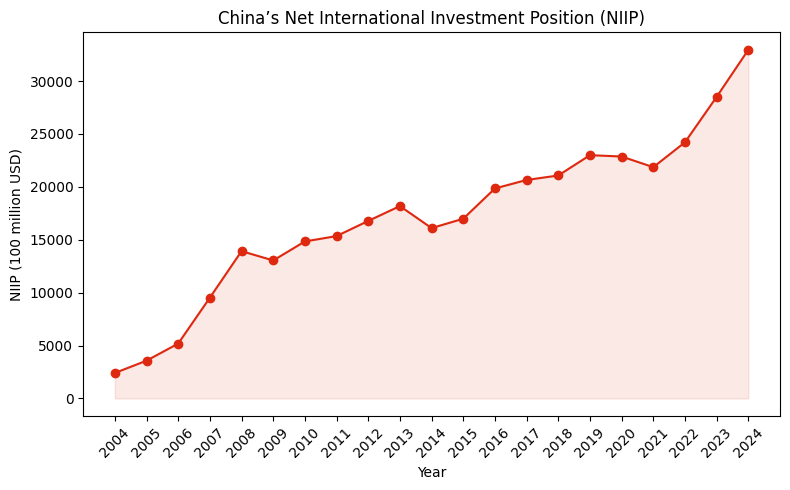

NIIP change (2004-2024):1268.77%


In [6]:
import matplotlib.pyplot as plt
# Define the Net International Investment Position (NIIP) (Assets - Liabilities)
niip = SAFE_data_long[SAFE_data_long["Category"] == "Net International Investment Position"]

plt.figure(figsize=(8,5))
plt.plot(niip.Year, niip.Value, 'o-', color="#DE2910" )

# Set x-ticks
plt.xticks(niip.Year, rotation=45)

# Shade under the line
plt.fill_between(niip.Year,niip.Value,color="#DE2910",alpha=0.1)

plt.title("China’s Net International Investment Position (NIIP)")
plt.xlabel("Year")
plt.ylabel("NIIP (100 million USD)")
plt.tight_layout()
plt.show()

# grab 2004 and 2024
NIIP_2004 = niip.loc[niip.Year == 2004, "Value"].item()
NIIP_2024= niip.loc[niip.Year == 2024, "Value"].item()

NIIP_change  = (NIIP_2024 / NIIP_2004 - 1) * 100
print(f"NIIP change (2004-2024):{NIIP_change:.2f}%")

**Answer 1.a** : Over the last twenty years China has been a net creditor for the rest a the world, as its external assets exceeds its liabilities by far. The NIIP increased by about 1.268% (not inflation-adjusted).

**1b**. Show graphically how the composition of China’s external assets and liabilities looked in 2007 at the onset of the Global Financial Crisis and how it looks today. Explain how China’s investments and liabilities have evolved over time. Which types of assets and liabilities have become more or less important?

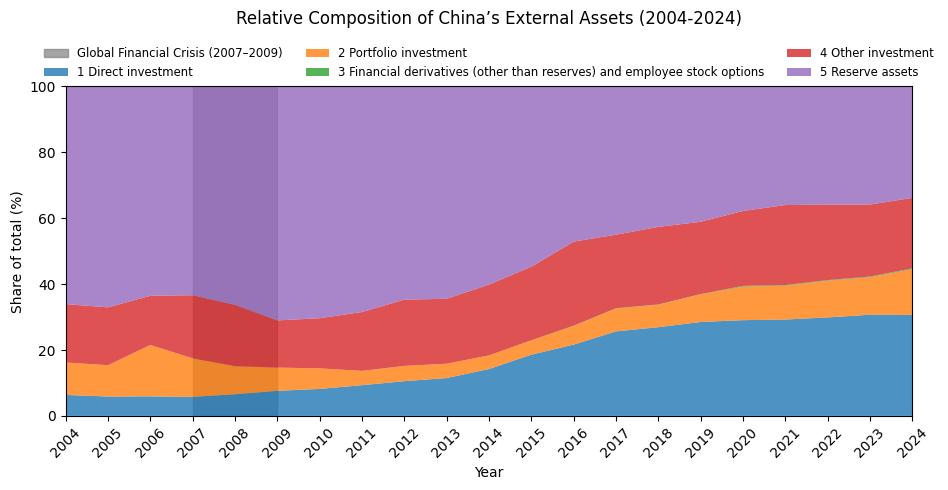

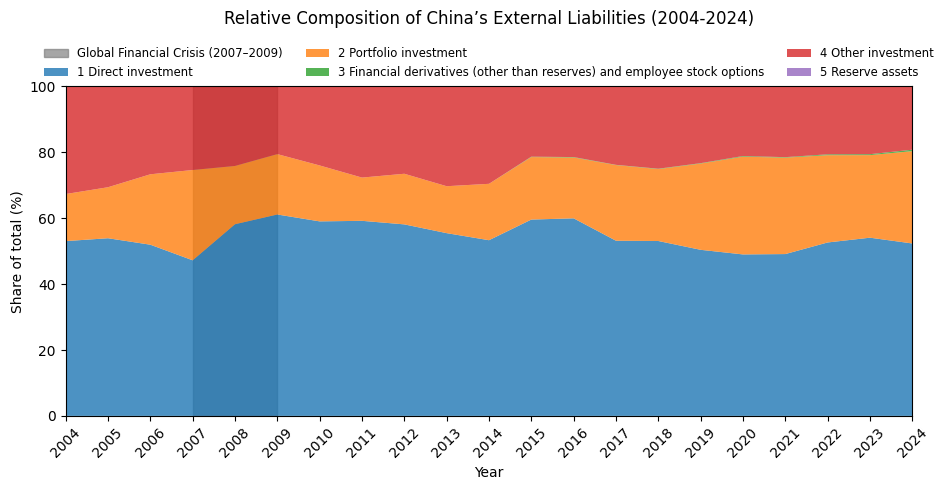

In [7]:

# Clean Category names
SAFE_data_long['Category_clean'] = (
    SAFE_data_long['Category']
      .astype(str) # Convert to string
      .str.strip() # Remove leading/trailing spaces
      .str.replace(' +', '_', regex=True) # Replace spaces with underscores
)

# Define the top balance categories
top5 = [
    "1_Direct_investment",
    "2_Portfolio_investment",
    "3_Financial_derivatives_(other_than_reserves)_and_employee_stock_options",
    "4_Other_investment",
    "5_Reserve_assets"
]

# Filter the data for the top 5 categories and create a new Dataframe
df_top5 = SAFE_data_long[
    SAFE_data_long['Category_clean'].isin(top5)
].copy()

# Pivot to wide format
pivot = df_top5.pivot_table(
    index='Year',
    columns=['Side','Category_clean'],
    values='Value',
    aggfunc='sum'
)

#Compute relative shares (%) for Assets
assets = pivot['Assets'].reindex(columns=top5, fill_value=0)
assets_pct = assets.div(assets.sum(axis=1), axis=0) * 100

#Compute relative shares (%) for Liabilities
liabs = pivot['Liabilities'].reindex(columns=top5, fill_value=0)
liabs_pct = liabs.div(liabs.sum(axis=1), axis=0) * 100

# Create labels for the legend
labels = [c.replace('_', ' ') for c in top5]


# Plot 1: Assets
#----------------------------------------------------------------

fig, ax = plt.subplots(figsize=(10,5))

# Shade the crisis and label it
ax.axvspan(2007, 2009, color='grey', alpha=0.7, label='Global Financial Crisis (2007–2009)')

# Set the stacked area
ax.stackplot(assets_pct.index, assets_pct.T, labels=labels, alpha=0.8)

# Formatting
ax.set_title(
    "Relative Composition of China’s External Assets (2004-2024)\n",
    pad=30
)
ax.set_xlabel("Year")
ax.set_ylabel("Share of total (%)")
ax.set_ylim(0, 100)

# X‐ticks as integers, rotated
ax.set_xticks(assets_pct.index)
ax.set_xticklabels(assets_pct.index.astype(int), rotation=45)

# Pin x‐axis to data range
ax.set_xlim(assets_pct.index.min(), assets_pct.index.max())

# Legend between title and plot
handles, labs = ax.get_legend_handles_labels()
ax.legend(
    handles, labs,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    fontsize='small',
    frameon=False
)

plt.tight_layout()
plt.show()


# Plot 2: Lieabilities
#----------------------------------------------------------------

fig, ax = plt.subplots(figsize=(10,5))

# Shade the crisis and label it
ax.axvspan(2007, 2009, color='grey', alpha=0.7, label='Global Financial Crisis (2007–2009)')

# Set stacked area
ax.stackplot(liabs_pct.index, liabs_pct.T, labels=labels, alpha=0.8)

# Formatting
ax.set_title(
    "Relative Composition of China’s External Liabilities (2004-2024)\n",
    pad=30
)
ax.set_xlabel("Year")
ax.set_ylabel("Share of total (%)")
ax.set_ylim(0, 100)

# X‐ticks as integers, rotated
ax.set_xticks(liabs_pct.index)
ax.set_xticklabels(liabs_pct.index.astype(int), rotation=45)

# Pin x‐axis to data range
ax.set_xlim(liabs_pct.index.min(), liabs_pct.index.max())

# Legend between title and plot
handles, labs = ax.get_legend_handles_labels()
ax.legend(
    handles, labs,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    fontsize='small',
    frameon=False
)

plt.tight_layout()
plt.show()

**Answer 1b:** 
During the global financial crisis china accumulated more reserve assets from roughly 55% to over 70% by 2008, while both direct and portfolio investment shares contracted below 10%. On the liability side, portfolio investment’s share plunged from about 25 % to under 20 % by 2009.

Long term, we can observe that China’s external assets have gradually rebalanced away from pure reserve accumulation toward higher-return allocation.Ddirect investment now accounts for roughly 30 % and portfolio investment about 15 % of assets (down from reserves’ 70 % in 2008 to 35 % today). On the liability side, foreign direct investment has stayed around 50 % of the total while portfolio liabilities have climbed steadily from below 20 % in 2009 to nearly 30 % by 2024, reflecting China’s deepening integration into global capital markets.










**1c.** Compare China’s international investment position to that of the US. Which asset and liability categories are more important on the US balance sheet?

https://www.bea.gov/data/intl-trade-investment/international-investment-position



In [ ]:
# Import US International Investment Position data
US_IIP_data = pd.read_excel(
    r"C:\Users\jonaw\OneDrive\Dokumente\Coding\Computational Economics"
    r"\Data Viz\China as a Global Creditor - a Data Excercise"
    r"\data\intinv424.xlsx",
    sheet_name="Table 1"
)

# Delete first row till row 5
US_IIP_data = US_IIP_data.iloc[3:].reset_index(drop=True)

# Delete from row 66
US_IIP_data = US_IIP_data.iloc[:66].copy()

# Rename the second column to "Category"
US_IIP_data.rename(columns={US_IIP_data.columns[1]: "Category"}, inplace=True)

# Rename the column 6 to Q3
US_IIP_data.rename(columns={US_IIP_data.columns[6]: "US_2024_Q4"}, inplace=True)

# Delete every column that except "Category" and "Q3"
US_IIP_data = US_IIP_data[["Category", "US_2024_Q4"]].copy()

# Delete the first row
US_IIP_data = US_IIP_data.iloc[1:].reset_index(drop=True)

US_IIP_data = US_IIP_data.reset_index(drop=True)

#Create a new “Side” column defaulting to NaN
US_IIP_data['Side'] = pd.NA

# Rows 4 through 35 → Assets
US_IIP_data.loc[4:35, 'Side'] = 'Assets'

# Rows 37 to end → Liabilities
US_IIP_data.loc[37:, 'Side'] = 'Liabilities'

# specify the row indices to keep
keep_rows = [7, 10, 15, 21, 27, 40, 43, 52, 58]

# subset US_IIP_data to only those rows, then reset the index
US_IIP_data = US_IIP_data.loc[keep_rows].reset_index(drop=True)

# Get SAFE data for 2024
SAFE_data_2024 = SAFE_data_long[SAFE_data_long["Year"] == 2024].copy()
SAFE_data_2024 = SAFE_data_2024.reset_index(drop=True)
SAFE_data_2024 = SAFE_data_2024[["Category_clean", "Value", "Side"]].copy()

# Rows to keep for SAFE data
keep_rows = [2, 11, 14, 15, 22, 29, 38, 41, 42]

# Subset SAFE data to only those rows, then reset the index
SAFE_data_2024 = SAFE_data_2024.loc[keep_rows].reset_index(drop=True)

# Merge the two DataFrames by row index
US_China_IIP = US_IIP_data.merge(
    SAFE_data_2024,
    left_index=True,
    right_index=True,
    suffixes=('_US', '_SAFE')
)
# Set US column as numeric
US_China_IIP["US_2024_Q4"] = pd.to_numeric(US_China_IIP["US_2024_Q4"], errors="coerce")

# Rename "Value" to China_2024_Q4
US_China_IIP.rename(columns={"Value": "China_2024_Q4"}, inplace=True)

# Delete "Side Safe" column
US_China_IIP.drop(columns=["Side_SAFE", "Category"], inplace=True)

#Reorder the columns
US_China_IIP = US_China_IIP[["Category_clean", "Side_US", "US_2024_Q4", "China_2024_Q4"]]

# Scale the US and China data to billion USD
US_China_IIP['China_2024_Q4'] = US_China_IIP['China_2024_Q4'] * 0.1

# Calculate the percentage of Assests and liabilities as new columns for China
US_China_IIP['China_2024_Q4_pct'] = (
    US_China_IIP['China_2024_Q4'] / US_China_IIP['China_2024_Q4'].sum()
) * 100

# Rename side
US_China_IIP = US_China_IIP.rename(columns={'Side_US':'Side'})

# Compute percent shares within each Side
US_China_IIP['US_pct'] = (
    US_China_IIP
      .groupby('Side')['US_2024_Q4']
      .transform(lambda x: x / x.sum() * 100)
)

US_China_IIP['China_pct'] = (
    US_China_IIP
      .groupby('Side')['China_2024_Q4']
      .transform(lambda x: x / x.sum() * 100)
)

# 3) Round the values to 1 decimal place
US_China_IIP[['US_pct','China_pct']] = US_China_IIP[['US_pct','China_pct']].round(1)




In [32]:

# 1) Rename for readability
df = US_China_IIP.rename(columns={
    'Category_clean':  'Category',
    'Side_US':         'Side',
    'US_2024_Q4':      'US (bn USD)',
    'China_2024_Q4':   'China (bn USD)',
    'US_pct':          'US share (%)',
    'China_pct':       'China share (%)'
})

# 2) Round numeric columns to one decimal place
for c in ['US (bn USD)', 'China (bn USD)', 'US share (%)', 'China share (%)']:
    df[c] = df[c].round(1)

# 3) Reorder columns
df = df[['Side', 'Category', 'US (bn USD)', 'China (bn USD)', 'US share (%)', 'China share (%)']]

# 4) Display as a nice HTML table
display(df)

,Side,Category,US (bn USD),China (bn USD),US share (%),China share (%)
0,Assets,1_Direct_investment,11265.4,3132.9,31.4,30.7
1,Assets,2_Portfolio_investment,15873.1,1417.3,44.2,13.9
2,Assets,3_Financial_derivatives_(other_than_reserves)_...,2316.2,24.2,6.5,0.2
3,Assets,4_Other_investment,5520.8,2186.7,15.4,21.4
4,Assets,5_Reserve_assets,909.9,3455.6,2.5,33.8
5,Liabilities,1_Direct_investment,17837.2,3622.4,28.7,52.3
6,Liabilities,2_Portfolio_investment,33086.9,1939.6,53.3,28.0
7,Liabilities,3_Financial_derivatives_(other_than_reserves)_...,2284.0,30.4,3.7,0.4
8,Liabilities,4_Other_investment,8909.5,1328.6,14.3,19.2
